In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%%capture
!pip install ftfy regex tqdm
!git clone https://github.com/openai/CLIP.git
!pip install git+https://github.com/openai/CLIP.git
import torch

print(torch.__version__)
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
mmm, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 135MiB/s]


In [ ]:
index=9

In [ ]:
folder_path = os.path.join(dir, str(index))

In [ ]:
sample_list = os.listdir(folder_path)

image_path = os.path.join(dir, random.choice(sample_list))

In [ ]:
image_path

'/content/drive/MyDrive/Adobe_Thirteenk_Images/544c00b1cb.jpg'

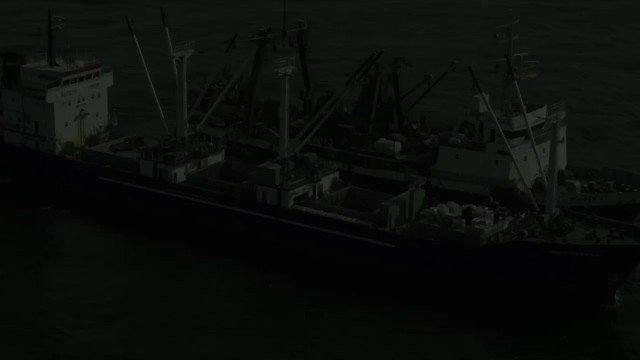

In [ ]:
x4_image

In [ ]:
import torch
import random
import os
from urllib.parse import urlparse
from torch.utils.data import Dataset, DataLoader
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data

        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        index = self.data.iloc[idx , 0]
        x1 = self.data.iloc[idx , 1]
        x2 = self.data.iloc[idx , 2]
        x3 = self.data.iloc[idx , 3]

        y = self.targets.iloc[idx ]
        folder_path = os.path.join(dir, str(index))
        sample_list = os.listdir(folder_path)
        if len(sample_list) >1:
            image_path = os.path.join(folder_path, random.choice(sample_list))

        else:
            image_path = os.path.join(folder_path, sample_list[0])

        x4_image = Image.open(image_path)
        x4_image = img.convert('RGB')
        x4_image = x4_image.resize((224, 224))
        x4_image = np.array(x4_image)

        text_1 = x1+x2+x3


        return text_1, y, x4_image

In [ ]:
image_path="/content/drive/MyDrive/just_for_checking/1.jpg"

In [ ]:
img_array.shape

(224, 224, 3)

In [ ]:
dir="/content/drive/MyDrive/just_for_checking"

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Final_last_data.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df.reset_index()

In [ ]:

df.columns

Index(['index', 'date', 'content', 'username', 'Image_Link', 'likes'], dtype='object')

In [ ]:
dir= "/content/drive/MyDrive/Adobe_Thirteenk_Images"

In [ ]:
df_new = df[['index', 'date', 'content', 'username', 'likes']]
df_new.columns

Index(['index', 'date', 'content', 'username', 'likes'], dtype='object')

In [ ]:
df1_final = df_new.copy()
df1_final["text"]=df1_final["date"]+df1_final["content"]+df1_final["username"]

In [ ]:
import pandas as pd

error_indices = []
new_rows = []

for index in range(len(df1_final["text"])):
    try:
        t = clip.tokenize(df1_final['text'].iloc[index]).to(device)
        new_rows.append(df1_final.iloc[index])

    except RuntimeError as e:
        error_indices.append(index)

df_final= pd.DataFrame(new_rows)

# Now, new_df contains only the rows without errors


In [ ]:
username_counts = df_final["username"].value_counts()
valid_companies = username_counts[username_counts > 2].index
df_final= df_final[df_final["username"].isin(valid_companies)].reset_index(drop=True)

In [ ]:
df_new=df_final

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_new, test_size=0.10, stratify=df_new['username'])

In [ ]:
train_dataset = CustomDataset(df_train, df_train['likes'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

test_dataset = CustomDataset(df_test, df_test['likes'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class LikesPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2 * 512, 512)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(512, 1)
        self.act_output = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 2 * 512)
        x = self.act1(self.hidden1(x))
        x = self.act_output(self.output(x))

        return x



In [ ]:
final_model = LikesPredictor().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

In [ ]:
epochs=10

In [ ]:
from tqdm import tqdm
for epoch in range(epochs):
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        text,y, x4_image = batch

        x4_image = [Image.fromarray(np.uint8(array)).convert('RGB') for array in x4_image]


        text = clip.tokenize(text).to(device)
        #x4_image = [preprocess(img).to(device) for img in x4_image]
        x4_image = torch.stack([preprocess(img).to(device) for img in x4_image])
        print(x4_image.shape)

        with torch.no_grad():
            x4_image = mmm.encode_image(x4_image)
            text = mmm.encode_text(text)
        x = torch.cat([x4_image, text], dim=1)
        # for i in range(batch_size):
        #     x.append(torch.cat( [x4_image[i], text[i]], dim=1))

        y = torch.tensor(y, dtype=torch.float32)

        y = y.view(-1,1).float().to(device)
        #labels = labels.view(-1, 1).float()
        preds = final_model(x.float())
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Finished epoch {epoch + 1}, latest loss {loss.item()}')
torch.save(final_model.state_dict(), "CLIP_final_model.pth")

Epoch 1/10:   0%|          | 0/152 [00:00<?, ?batch/s]<ipython-input-98-a884ff5b55bb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
Epoch 1/10:   1%|          | 1/152 [00:28<1:11:35, 28.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   1%|▏         | 2/152 [00:58<1:12:57, 29.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   2%|▏         | 3/152 [01:27<1:12:57, 29.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   3%|▎         | 4/152 [01:56<1:12:15, 29.29s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   3%|▎         | 5/152 [02:25<1:11:18, 29.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   4%|▍         | 6/152 [02:49<1:06:47, 27.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   5%|▍         | 7/152 [03:17<1:06:09, 27.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   5%|▌         | 8/152 [03:46<1:07:16, 28.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   6%|▌         | 9/152 [04:14<1:06:21, 27.84s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   7%|▋         | 10/152 [04:37<1:02:33, 26.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   7%|▋         | 11/152 [05:01<1:00:50, 25.89s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   8%|▊         | 12/152 [05:26<59:31, 25.51s/batch]  

torch.Size([64, 3, 224, 224])


Epoch 1/10:   9%|▊         | 13/152 [05:51<58:41, 25.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:   9%|▉         | 14/152 [06:14<56:42, 24.65s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  10%|▉         | 15/152 [06:39<56:37, 24.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  11%|█         | 16/152 [07:03<55:26, 24.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  11%|█         | 17/152 [07:26<54:06, 24.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  12%|█▏        | 18/152 [07:50<53:30, 23.96s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  12%|█▎        | 19/152 [08:14<52:58, 23.90s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  13%|█▎        | 20/152 [08:36<51:29, 23.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  14%|█▍        | 21/152 [09:00<51:20, 23.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  14%|█▍        | 22/152 [09:29<54:49, 25.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  15%|█▌        | 23/152 [09:51<52:19, 24.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  16%|█▌        | 24/152 [10:14<51:15, 24.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  16%|█▋        | 25/152 [10:39<50:58, 24.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  17%|█▋        | 26/152 [11:03<50:56, 24.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  18%|█▊        | 27/152 [11:29<51:25, 24.68s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  18%|█▊        | 28/152 [11:53<50:26, 24.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  19%|█▉        | 29/152 [12:16<49:34, 24.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  20%|█▉        | 30/152 [12:40<48:47, 24.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  20%|██        | 31/152 [13:02<47:07, 23.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  21%|██        | 32/152 [13:27<47:42, 23.86s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  22%|██▏       | 33/152 [13:50<46:44, 23.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  22%|██▏       | 34/152 [14:13<46:25, 23.60s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  23%|██▎       | 35/152 [14:36<45:34, 23.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  24%|██▎       | 36/152 [15:00<45:39, 23.62s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  24%|██▍       | 37/152 [15:19<42:05, 21.96s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  25%|██▌       | 38/152 [15:44<43:52, 23.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  26%|██▌       | 39/152 [16:08<43:37, 23.17s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  26%|██▋       | 40/152 [16:32<44:12, 23.68s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  27%|██▋       | 41/152 [16:57<44:00, 23.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  28%|██▊       | 42/152 [17:21<44:03, 24.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  28%|██▊       | 43/152 [17:46<43:56, 24.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  29%|██▉       | 44/152 [18:09<42:49, 23.79s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  30%|██▉       | 45/152 [18:31<41:49, 23.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  30%|███       | 46/152 [18:55<41:21, 23.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  31%|███       | 47/152 [19:18<41:10, 23.53s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  32%|███▏      | 48/152 [19:43<41:22, 23.87s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  32%|███▏      | 49/152 [20:06<40:33, 23.63s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  33%|███▎      | 50/152 [20:28<39:06, 23.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  34%|███▎      | 51/152 [20:51<39:04, 23.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  34%|███▍      | 52/152 [21:15<38:52, 23.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  35%|███▍      | 53/152 [21:38<38:29, 23.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  36%|███▌      | 54/152 [22:00<37:32, 22.98s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  36%|███▌      | 55/152 [22:25<38:03, 23.54s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  37%|███▋      | 56/152 [22:51<38:46, 24.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  38%|███▊      | 57/152 [23:15<38:24, 24.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  38%|███▊      | 58/152 [23:41<38:43, 24.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  39%|███▉      | 59/152 [24:05<37:43, 24.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  39%|███▉      | 60/152 [24:30<37:40, 24.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  40%|████      | 61/152 [24:53<36:42, 24.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  41%|████      | 62/152 [25:19<37:07, 24.75s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  41%|████▏     | 63/152 [25:44<36:37, 24.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  42%|████▏     | 64/152 [26:06<35:03, 23.90s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  43%|████▎     | 65/152 [26:28<33:48, 23.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  43%|████▎     | 66/152 [26:51<33:29, 23.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  44%|████▍     | 67/152 [27:16<33:45, 23.83s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  45%|████▍     | 68/152 [27:37<32:13, 23.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  45%|████▌     | 69/152 [27:58<31:02, 22.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  46%|████▌     | 70/152 [28:23<31:39, 23.17s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  47%|████▋     | 71/152 [28:46<31:03, 23.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  47%|████▋     | 72/152 [29:09<30:49, 23.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  48%|████▊     | 73/152 [29:31<30:01, 22.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  49%|████▊     | 74/152 [29:52<28:42, 22.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  49%|████▉     | 75/152 [30:17<29:28, 22.96s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  50%|█████     | 76/152 [30:39<28:45, 22.70s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  51%|█████     | 77/152 [31:02<28:38, 22.91s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  51%|█████▏    | 78/152 [31:27<28:51, 23.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  52%|█████▏    | 79/152 [31:51<28:55, 23.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  53%|█████▎    | 80/152 [32:16<28:52, 24.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  53%|█████▎    | 81/152 [32:39<28:09, 23.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  54%|█████▍    | 82/152 [33:05<28:30, 24.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  55%|█████▍    | 83/152 [33:25<26:39, 23.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  55%|█████▌    | 84/152 [33:49<26:23, 23.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  56%|█████▌    | 85/152 [34:13<26:09, 23.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  57%|█████▋    | 86/152 [34:35<25:19, 23.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  57%|█████▋    | 87/152 [34:58<24:54, 23.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  58%|█████▊    | 88/152 [35:24<25:35, 23.99s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  59%|█████▊    | 89/152 [35:48<25:01, 23.84s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  59%|█████▉    | 90/152 [36:12<24:42, 23.91s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  60%|█████▉    | 91/152 [36:38<25:10, 24.76s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  61%|██████    | 92/152 [37:05<25:13, 25.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  61%|██████    | 93/152 [37:28<24:21, 24.77s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  62%|██████▏   | 94/152 [37:52<23:31, 24.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  62%|██████▎   | 95/152 [38:18<23:34, 24.81s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  63%|██████▎   | 96/152 [38:44<23:35, 25.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  64%|██████▍   | 97/152 [39:10<23:19, 25.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  64%|██████▍   | 98/152 [39:35<22:54, 25.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  65%|██████▌   | 99/152 [40:01<22:28, 25.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  66%|██████▌   | 100/152 [40:23<21:10, 24.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  66%|██████▋   | 101/152 [40:48<20:59, 24.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  67%|██████▋   | 102/152 [41:11<20:10, 24.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  68%|██████▊   | 103/152 [41:36<19:52, 24.35s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  68%|██████▊   | 104/152 [42:02<20:00, 25.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  69%|██████▉   | 105/152 [42:29<19:58, 25.49s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  70%|██████▉   | 106/152 [42:54<19:25, 25.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  70%|███████   | 107/152 [43:16<18:16, 24.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  71%|███████   | 108/152 [43:42<18:12, 24.82s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  72%|███████▏  | 109/152 [44:07<17:50, 24.89s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  72%|███████▏  | 110/152 [44:32<17:26, 24.92s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  73%|███████▎  | 111/152 [44:57<16:56, 24.79s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  74%|███████▎  | 112/152 [45:23<16:54, 25.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  74%|███████▍  | 113/152 [45:47<16:07, 24.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  75%|███████▌  | 114/152 [46:15<16:17, 25.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  76%|███████▌  | 115/152 [46:36<15:03, 24.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  76%|███████▋  | 116/152 [46:58<14:16, 23.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  77%|███████▋  | 117/152 [47:23<13:57, 23.92s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  78%|███████▊  | 118/152 [47:43<13:00, 22.95s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  78%|███████▊  | 119/152 [48:05<12:27, 22.66s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  79%|███████▉  | 120/152 [48:34<13:06, 24.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  80%|███████▉  | 121/152 [49:01<12:58, 25.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  80%|████████  | 122/152 [49:25<12:30, 25.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  81%|████████  | 123/152 [49:51<12:10, 25.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  82%|████████▏ | 124/152 [50:13<11:19, 24.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  82%|████████▏ | 125/152 [50:36<10:45, 23.91s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  83%|████████▎ | 126/152 [51:00<10:22, 23.93s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  84%|████████▎ | 127/152 [51:27<10:19, 24.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  84%|████████▍ | 128/152 [51:54<10:08, 25.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  85%|████████▍ | 129/152 [52:20<09:52, 25.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  86%|████████▌ | 130/152 [52:47<09:30, 25.91s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  86%|████████▌ | 131/152 [53:16<09:26, 26.98s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  87%|████████▋ | 132/152 [53:44<09:03, 27.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  88%|████████▊ | 133/152 [54:08<08:18, 26.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  88%|████████▊ | 134/152 [54:35<07:56, 26.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  89%|████████▉ | 135/152 [55:01<07:27, 26.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  89%|████████▉ | 136/152 [55:27<06:59, 26.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  90%|█████████ | 137/152 [55:52<06:29, 25.97s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  91%|█████████ | 138/152 [56:20<06:13, 26.65s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  91%|█████████▏| 139/152 [56:46<05:41, 26.29s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  92%|█████████▏| 140/152 [57:12<05:14, 26.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  93%|█████████▎| 141/152 [57:38<04:49, 26.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  93%|█████████▎| 142/152 [57:59<04:05, 24.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  94%|█████████▍| 143/152 [58:23<03:41, 24.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  95%|█████████▍| 144/152 [58:47<03:14, 24.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  95%|█████████▌| 145/152 [59:09<02:45, 23.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  96%|█████████▌| 146/152 [59:34<02:23, 23.94s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  97%|█████████▋| 147/152 [1:00:03<02:06, 25.35s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  97%|█████████▋| 148/152 [1:00:27<01:40, 25.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  98%|█████████▊| 149/152 [1:00:51<01:14, 24.80s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  99%|█████████▊| 150/152 [1:01:14<00:48, 24.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10:  99%|█████████▉| 151/152 [1:01:38<00:24, 24.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 1/10: 100%|██████████| 152/152 [1:01:55<00:00, 24.44s/batch]


torch.Size([52, 3, 224, 224])
Finished epoch 1, latest loss 91164656.0


Epoch 2/10:   1%|          | 1/152 [00:01<05:00,  1.99s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   1%|▏         | 2/152 [00:02<03:30,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   2%|▏         | 3/152 [00:04<04:10,  1.68s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   3%|▎         | 4/152 [00:06<04:06,  1.66s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   3%|▎         | 5/152 [00:07<03:42,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   4%|▍         | 6/152 [00:09<03:23,  1.40s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   5%|▍         | 7/152 [00:11<04:05,  1.70s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   5%|▌         | 8/152 [00:11<03:09,  1.32s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   6%|▌         | 9/152 [00:13<03:18,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   7%|▋         | 10/152 [00:14<03:19,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   7%|▋         | 11/152 [00:15<02:40,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   8%|▊         | 12/152 [00:17<03:02,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   9%|▊         | 13/152 [00:17<02:28,  1.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:   9%|▉         | 14/152 [00:19<03:10,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  10%|▉         | 15/152 [00:22<03:55,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  11%|█         | 16/152 [00:22<03:04,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  11%|█         | 17/152 [00:25<03:45,  1.67s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  12%|█▏        | 18/152 [00:27<04:14,  1.90s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  12%|█▎        | 19/152 [00:28<03:52,  1.75s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  13%|█▎        | 20/152 [00:29<03:01,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  14%|█▍        | 21/152 [00:31<03:17,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  14%|█▍        | 22/152 [00:31<02:39,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  15%|█▌        | 23/152 [00:32<02:35,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  16%|█▌        | 24/152 [00:34<02:46,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  16%|█▋        | 25/152 [00:35<02:37,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  17%|█▋        | 26/152 [00:38<03:37,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  18%|█▊        | 27/152 [00:39<03:08,  1.50s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  18%|█▊        | 28/152 [00:41<03:19,  1.61s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  19%|█▉        | 29/152 [00:42<03:12,  1.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  20%|█▉        | 30/152 [00:43<02:48,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  20%|██        | 31/152 [00:44<02:14,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  21%|██        | 32/152 [00:46<03:08,  1.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  22%|██▏       | 33/152 [00:48<03:18,  1.67s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  22%|██▏       | 34/152 [00:49<02:51,  1.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  23%|██▎       | 35/152 [00:50<02:42,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  24%|██▎       | 36/152 [00:52<02:41,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  24%|██▍       | 37/152 [00:54<02:54,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  25%|██▌       | 38/152 [00:54<02:18,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  26%|██▌       | 39/152 [00:56<02:24,  1.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  26%|██▋       | 40/152 [00:59<03:43,  1.99s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  27%|██▋       | 41/152 [01:00<03:14,  1.75s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  28%|██▊       | 42/152 [01:02<03:14,  1.76s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  28%|██▊       | 43/152 [01:03<02:50,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  29%|██▉       | 44/152 [01:05<02:44,  1.52s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  30%|██▉       | 45/152 [01:07<03:10,  1.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  30%|███       | 46/152 [01:08<02:43,  1.55s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  31%|███       | 47/152 [01:09<02:10,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  32%|███▏      | 48/152 [01:12<03:00,  1.74s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  32%|███▏      | 49/152 [01:13<02:41,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  33%|███▎      | 50/152 [01:16<03:22,  1.98s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  34%|███▎      | 51/152 [01:18<03:19,  1.97s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  34%|███▍      | 52/152 [01:19<02:55,  1.76s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  35%|███▍      | 53/152 [01:20<02:29,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  36%|███▌      | 54/152 [01:22<02:51,  1.75s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  36%|███▌      | 55/152 [01:24<02:43,  1.68s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  37%|███▋      | 56/152 [01:25<02:28,  1.55s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  38%|███▊      | 57/152 [01:26<02:14,  1.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  38%|███▊      | 58/152 [01:27<02:02,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  39%|███▉      | 59/152 [01:30<02:46,  1.79s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  39%|███▉      | 60/152 [01:31<02:35,  1.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  40%|████      | 61/152 [01:34<03:10,  2.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  41%|████      | 62/152 [01:36<02:50,  1.90s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  41%|████▏     | 63/152 [01:38<02:48,  1.90s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  42%|████▏     | 64/152 [01:39<02:26,  1.67s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  43%|████▎     | 65/152 [01:40<02:22,  1.64s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  43%|████▎     | 66/152 [01:42<02:07,  1.48s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  44%|████▍     | 67/152 [01:43<01:55,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  45%|████▍     | 68/152 [01:45<02:18,  1.65s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  45%|████▌     | 69/152 [01:46<02:01,  1.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  46%|████▌     | 70/152 [01:50<02:49,  2.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  47%|████▋     | 71/152 [01:51<02:33,  1.89s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  47%|████▋     | 72/152 [01:54<02:45,  2.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  48%|████▊     | 73/152 [01:55<02:39,  2.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  49%|████▊     | 74/152 [01:57<02:33,  1.97s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  49%|████▉     | 75/152 [01:58<02:14,  1.74s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  50%|█████     | 76/152 [02:00<02:12,  1.74s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  51%|█████     | 77/152 [02:02<02:08,  1.71s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  51%|█████▏    | 78/152 [02:05<02:33,  2.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  52%|█████▏    | 79/152 [02:07<02:29,  2.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  53%|█████▎    | 80/152 [02:08<02:08,  1.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  53%|█████▎    | 81/152 [02:09<01:49,  1.54s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  54%|█████▍    | 82/152 [02:11<01:56,  1.67s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  55%|█████▍    | 83/152 [02:12<01:38,  1.43s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  55%|█████▌    | 84/152 [02:14<01:56,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  56%|█████▌    | 85/152 [02:15<01:31,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  57%|█████▋    | 86/152 [02:16<01:27,  1.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  57%|█████▋    | 87/152 [02:17<01:19,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  58%|█████▊    | 88/152 [02:19<01:34,  1.48s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  59%|█████▊    | 89/152 [02:21<01:41,  1.62s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  59%|█████▉    | 90/152 [02:23<01:53,  1.83s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  60%|█████▉    | 91/152 [02:25<01:45,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  61%|██████    | 92/152 [02:26<01:27,  1.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  61%|██████    | 93/152 [02:26<01:16,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  62%|██████▏   | 94/152 [02:28<01:24,  1.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  62%|██████▎   | 95/152 [02:29<01:17,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  63%|██████▎   | 96/152 [02:33<01:52,  2.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  64%|██████▍   | 97/152 [02:35<01:58,  2.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  64%|██████▍   | 98/152 [02:38<02:03,  2.29s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  65%|██████▌   | 99/152 [02:40<01:52,  2.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  66%|██████▌   | 100/152 [02:42<01:53,  2.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  66%|██████▋   | 101/152 [02:44<01:40,  1.96s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  67%|██████▋   | 102/152 [02:44<01:16,  1.54s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  68%|██████▊   | 103/152 [02:45<01:07,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  68%|██████▊   | 104/152 [02:48<01:27,  1.82s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  69%|██████▉   | 105/152 [02:50<01:32,  1.96s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  70%|██████▉   | 106/152 [02:52<01:29,  1.94s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  70%|███████   | 107/152 [02:54<01:20,  1.79s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  71%|███████   | 108/152 [02:54<01:01,  1.40s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  72%|███████▏  | 109/152 [02:56<01:08,  1.60s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  72%|███████▏  | 110/152 [02:58<01:12,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  73%|███████▎  | 111/152 [02:59<01:04,  1.58s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  74%|███████▎  | 112/152 [03:00<00:52,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  74%|███████▍  | 113/152 [03:01<00:47,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  75%|███████▌  | 114/152 [03:02<00:39,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  76%|███████▌  | 115/152 [03:04<00:48,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  76%|███████▋  | 116/152 [03:04<00:38,  1.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  77%|███████▋  | 117/152 [03:07<00:56,  1.62s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  78%|███████▊  | 118/152 [03:08<00:47,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  78%|███████▊  | 119/152 [03:10<00:49,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  79%|███████▉  | 120/152 [03:10<00:38,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  80%|███████▉  | 121/152 [03:13<00:48,  1.57s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  80%|████████  | 122/152 [03:16<01:05,  2.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  81%|████████  | 123/152 [03:17<00:53,  1.83s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  82%|████████▏ | 124/152 [03:18<00:44,  1.58s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  82%|████████▏ | 125/152 [03:20<00:42,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  83%|████████▎ | 126/152 [03:22<00:48,  1.86s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  84%|████████▎ | 127/152 [03:23<00:40,  1.63s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  84%|████████▍ | 128/152 [03:25<00:37,  1.54s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  85%|████████▍ | 129/152 [03:25<00:28,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  86%|████████▌ | 130/152 [03:27<00:31,  1.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  86%|████████▌ | 131/152 [03:29<00:33,  1.59s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  87%|████████▋ | 132/152 [03:30<00:28,  1.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  88%|████████▊ | 133/152 [03:33<00:36,  1.91s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  88%|████████▊ | 134/152 [03:36<00:39,  2.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  89%|████████▉ | 135/152 [03:37<00:33,  1.97s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  89%|████████▉ | 136/152 [03:39<00:29,  1.83s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  90%|█████████ | 137/152 [03:41<00:28,  1.88s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  91%|█████████ | 138/152 [03:43<00:28,  2.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  91%|█████████▏| 139/152 [03:44<00:22,  1.70s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  92%|█████████▏| 140/152 [03:46<00:19,  1.64s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  93%|█████████▎| 141/152 [03:48<00:19,  1.74s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  93%|█████████▎| 142/152 [03:51<00:20,  2.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  94%|█████████▍| 143/152 [03:54<00:22,  2.52s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  95%|█████████▍| 144/152 [03:55<00:17,  2.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  95%|█████████▌| 145/152 [03:56<00:12,  1.79s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  96%|█████████▌| 146/152 [03:57<00:09,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  97%|█████████▋| 147/152 [04:00<00:09,  1.95s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  97%|█████████▋| 148/152 [04:01<00:06,  1.66s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  98%|█████████▊| 149/152 [04:05<00:07,  2.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  99%|█████████▊| 150/152 [04:07<00:04,  2.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10:  99%|█████████▉| 151/152 [04:09<00:02,  2.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 2/10: 100%|██████████| 152/152 [04:11<00:00,  1.65s/batch]


torch.Size([52, 3, 224, 224])
Finished epoch 2, latest loss 14493363.0


Epoch 3/10:   1%|          | 1/152 [00:01<03:32,  1.40s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   1%|▏         | 2/152 [00:03<04:54,  1.97s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   2%|▏         | 3/152 [00:04<03:16,  1.32s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   3%|▎         | 4/152 [00:06<03:37,  1.47s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   3%|▎         | 5/152 [00:07<03:31,  1.44s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   4%|▍         | 6/152 [00:10<04:34,  1.88s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   5%|▍         | 7/152 [00:11<04:01,  1.66s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   5%|▌         | 8/152 [00:12<03:50,  1.60s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   6%|▌         | 9/152 [00:13<03:00,  1.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   7%|▋         | 10/152 [00:15<03:46,  1.59s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   7%|▋         | 11/152 [00:16<02:58,  1.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   8%|▊         | 12/152 [00:17<03:04,  1.32s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   9%|▊         | 13/152 [00:19<03:08,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:   9%|▉         | 14/152 [00:20<03:05,  1.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  10%|▉         | 15/152 [00:21<03:13,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  11%|█         | 16/152 [00:23<03:20,  1.48s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  11%|█         | 17/152 [00:24<02:48,  1.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  12%|█▏        | 18/152 [00:25<02:38,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  12%|█▎        | 19/152 [00:26<02:31,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  13%|█▎        | 20/152 [00:28<03:13,  1.47s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  14%|█▍        | 21/152 [00:30<03:45,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  14%|█▍        | 22/152 [00:32<03:50,  1.77s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  15%|█▌        | 23/152 [00:33<03:20,  1.55s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  16%|█▌        | 24/152 [00:35<03:36,  1.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  16%|█▋        | 25/152 [00:38<04:21,  2.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  17%|█▋        | 26/152 [00:39<03:39,  1.74s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  18%|█▊        | 27/152 [00:41<03:26,  1.65s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  18%|█▊        | 28/152 [00:42<03:02,  1.47s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  19%|█▉        | 29/152 [00:42<02:25,  1.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  20%|█▉        | 30/152 [00:43<02:17,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  20%|██        | 31/152 [00:44<02:06,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  21%|██        | 32/152 [00:46<02:18,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  22%|██▏       | 33/152 [00:47<02:21,  1.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  22%|██▏       | 34/152 [00:49<02:57,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  23%|██▎       | 35/152 [00:50<02:26,  1.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  24%|██▎       | 36/152 [00:50<02:06,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  24%|██▍       | 37/152 [00:52<02:29,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  25%|██▌       | 38/152 [00:53<02:16,  1.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  26%|██▌       | 39/152 [00:54<02:07,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  26%|██▋       | 40/152 [00:55<01:45,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  27%|██▋       | 41/152 [00:56<02:06,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  28%|██▊       | 42/152 [00:58<02:13,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  28%|██▊       | 43/152 [00:59<02:05,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  29%|██▉       | 44/152 [01:00<01:58,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  30%|██▉       | 45/152 [01:02<02:23,  1.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  30%|███       | 46/152 [01:02<02:00,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  31%|███       | 47/152 [01:03<01:59,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  32%|███▏      | 48/152 [01:05<02:16,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  32%|███▏      | 49/152 [01:07<02:19,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  33%|███▎      | 50/152 [01:07<02:06,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  34%|███▎      | 51/152 [01:08<01:52,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  34%|███▍      | 52/152 [01:10<02:02,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  35%|███▍      | 53/152 [01:11<01:53,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  36%|███▌      | 54/152 [01:12<01:50,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  36%|███▌      | 55/152 [01:13<01:45,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  37%|███▋      | 56/152 [01:14<01:55,  1.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  38%|███▊      | 57/152 [01:15<01:34,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  38%|███▊      | 58/152 [01:17<02:04,  1.32s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  39%|███▉      | 59/152 [01:18<01:44,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  39%|███▉      | 60/152 [01:19<01:44,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  40%|████      | 61/152 [01:20<01:49,  1.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  41%|████      | 62/152 [01:22<02:04,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  41%|████▏     | 63/152 [01:22<01:40,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  42%|████▏     | 64/152 [01:23<01:37,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  43%|████▎     | 65/152 [01:24<01:31,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  43%|████▎     | 66/152 [01:26<01:40,  1.17s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  44%|████▍     | 67/152 [01:27<01:41,  1.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  45%|████▍     | 68/152 [01:29<01:47,  1.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  45%|████▌     | 69/152 [01:30<01:50,  1.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  46%|████▌     | 70/152 [01:32<01:54,  1.40s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  47%|████▋     | 71/152 [01:33<01:45,  1.30s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  47%|████▋     | 72/152 [01:34<01:44,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  48%|████▊     | 73/152 [01:36<02:05,  1.59s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  49%|████▊     | 74/152 [01:38<02:12,  1.70s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  49%|████▉     | 75/152 [01:39<01:43,  1.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  50%|█████     | 76/152 [01:39<01:23,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  51%|█████     | 77/152 [01:41<01:26,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  51%|█████▏    | 78/152 [01:41<01:11,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  52%|█████▏    | 79/152 [01:42<01:00,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  53%|█████▎    | 80/152 [01:44<01:37,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  53%|█████▎    | 81/152 [01:46<01:55,  1.63s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  54%|█████▍    | 82/152 [01:48<01:58,  1.69s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  55%|█████▍    | 83/152 [01:50<01:50,  1.61s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  55%|█████▌    | 84/152 [01:51<01:35,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  56%|█████▌    | 85/152 [01:52<01:32,  1.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  57%|█████▋    | 86/152 [01:54<01:39,  1.50s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  57%|█████▋    | 87/152 [01:57<02:16,  2.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  58%|█████▊    | 88/152 [01:58<01:56,  1.82s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  59%|█████▊    | 89/152 [02:00<01:48,  1.72s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  59%|█████▉    | 90/152 [02:01<01:32,  1.49s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  60%|█████▉    | 91/152 [02:03<01:48,  1.78s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  61%|██████    | 92/152 [02:04<01:29,  1.49s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  61%|██████    | 93/152 [02:05<01:10,  1.20s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  62%|██████▏   | 94/152 [02:06<01:05,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  62%|██████▎   | 95/152 [02:07<01:10,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  63%|██████▎   | 96/152 [02:09<01:27,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  64%|██████▍   | 97/152 [02:11<01:35,  1.73s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  64%|██████▍   | 98/152 [02:13<01:24,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  65%|██████▌   | 99/152 [02:14<01:13,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  66%|██████▌   | 100/152 [02:14<01:03,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  66%|██████▋   | 101/152 [02:16<01:12,  1.42s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  67%|██████▋   | 102/152 [02:17<00:57,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  68%|██████▊   | 103/152 [02:19<01:14,  1.51s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  68%|██████▊   | 104/152 [02:20<01:05,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  69%|██████▉   | 105/152 [02:21<00:58,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  70%|██████▉   | 106/152 [02:22<00:47,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  70%|███████   | 107/152 [02:22<00:39,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  71%|███████   | 108/152 [02:24<00:48,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  72%|███████▏  | 109/152 [02:25<00:48,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  72%|███████▏  | 110/152 [02:26<00:47,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  73%|███████▎  | 111/152 [02:27<00:44,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  74%|███████▎  | 112/152 [02:28<00:36,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  74%|███████▍  | 113/152 [02:29<00:36,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  75%|███████▌  | 114/152 [02:30<00:35,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  76%|███████▌  | 115/152 [02:31<00:34,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  76%|███████▋  | 116/152 [02:32<00:39,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  77%|███████▋  | 117/152 [02:35<01:01,  1.75s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  78%|███████▊  | 118/152 [02:37<00:57,  1.70s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  78%|███████▊  | 119/152 [02:38<00:54,  1.65s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  79%|███████▉  | 120/152 [02:39<00:43,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  80%|███████▉  | 121/152 [02:40<00:36,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  80%|████████  | 122/152 [02:42<00:44,  1.50s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  81%|████████  | 123/152 [02:44<00:50,  1.73s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  82%|████████▏ | 124/152 [02:45<00:38,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  82%|████████▏ | 125/152 [02:46<00:33,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  83%|████████▎ | 126/152 [02:47<00:30,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  84%|████████▎ | 127/152 [02:48<00:27,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  84%|████████▍ | 128/152 [02:48<00:22,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  85%|████████▍ | 129/152 [02:49<00:18,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  86%|████████▌ | 130/152 [02:51<00:27,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  86%|████████▌ | 131/152 [02:54<00:34,  1.63s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  87%|████████▋ | 132/152 [02:54<00:26,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  88%|████████▊ | 133/152 [02:55<00:20,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  88%|████████▊ | 134/152 [02:56<00:18,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  89%|████████▉ | 135/152 [02:57<00:17,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  89%|████████▉ | 136/152 [02:57<00:15,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  90%|█████████ | 137/152 [02:58<00:14,  1.03batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  91%|█████████ | 138/152 [03:01<00:20,  1.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  91%|█████████▏| 139/152 [03:02<00:15,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  92%|█████████▏| 140/152 [03:03<00:14,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  93%|█████████▎| 141/152 [03:06<00:20,  1.86s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  93%|█████████▎| 142/152 [03:07<00:15,  1.60s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  94%|█████████▍| 143/152 [03:08<00:12,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  95%|█████████▍| 144/152 [03:09<00:10,  1.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  95%|█████████▌| 145/152 [03:11<00:10,  1.56s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  96%|█████████▌| 146/152 [03:12<00:08,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  97%|█████████▋| 147/152 [03:14<00:07,  1.50s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  97%|█████████▋| 148/152 [03:15<00:04,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  98%|█████████▊| 149/152 [03:15<00:02,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  99%|█████████▊| 150/152 [03:17<00:02,  1.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10:  99%|█████████▉| 151/152 [03:19<00:01,  1.45s/batch]

torch.Size([64, 3, 224, 224])


Epoch 3/10: 100%|██████████| 152/152 [03:19<00:00,  1.32s/batch]


torch.Size([52, 3, 224, 224])
Finished epoch 3, latest loss 41998268.0


Epoch 4/10:   1%|          | 1/152 [00:00<01:20,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   1%|▏         | 2/152 [00:01<01:19,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   2%|▏         | 3/152 [00:01<01:17,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   3%|▎         | 4/152 [00:02<01:42,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   3%|▎         | 5/152 [00:03<02:16,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   4%|▍         | 6/152 [00:04<02:17,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   5%|▍         | 7/152 [00:06<02:59,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   5%|▌         | 8/152 [00:08<03:04,  1.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   6%|▌         | 9/152 [00:09<02:48,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   7%|▋         | 10/152 [00:10<02:55,  1.24s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   7%|▋         | 11/152 [00:11<02:51,  1.22s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   8%|▊         | 12/152 [00:12<02:48,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   9%|▊         | 13/152 [00:13<02:43,  1.17s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:   9%|▉         | 14/152 [00:15<02:43,  1.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  10%|▉         | 15/152 [00:15<02:14,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  11%|█         | 16/152 [00:16<01:54,  1.19batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  11%|█         | 17/152 [00:16<01:40,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  12%|█▏        | 18/152 [00:17<01:31,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  12%|█▎        | 19/152 [00:18<02:05,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  13%|█▎        | 20/152 [00:20<02:57,  1.35s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  14%|█▍        | 21/152 [00:21<02:24,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  14%|█▍        | 22/152 [00:22<01:59,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  15%|█▌        | 23/152 [00:24<02:41,  1.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  16%|█▌        | 24/152 [00:24<02:17,  1.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  16%|█▋        | 25/152 [00:25<02:00,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  17%|█▋        | 26/152 [00:26<02:07,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  18%|█▊        | 27/152 [00:27<02:05,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  18%|█▊        | 28/152 [00:28<01:53,  1.10batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  19%|█▉        | 29/152 [00:29<02:12,  1.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  20%|█▉        | 30/152 [00:30<02:08,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  20%|██        | 31/152 [00:31<02:13,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  21%|██        | 32/152 [00:32<02:08,  1.07s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  22%|██▏       | 33/152 [00:33<01:47,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  22%|██▏       | 34/152 [00:34<01:49,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  23%|██▎       | 35/152 [00:35<02:02,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  24%|██▎       | 36/152 [00:36<02:01,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  24%|██▍       | 37/152 [00:39<02:52,  1.50s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  25%|██▌       | 38/152 [00:40<02:38,  1.39s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  26%|██▌       | 39/152 [00:41<02:28,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  26%|██▋       | 40/152 [00:42<02:18,  1.23s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  27%|██▋       | 41/152 [00:44<02:27,  1.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  28%|██▊       | 42/152 [00:45<02:30,  1.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  28%|██▊       | 43/152 [00:46<02:17,  1.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  29%|██▉       | 44/152 [00:47<02:16,  1.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  30%|██▉       | 45/152 [00:48<02:04,  1.17s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  30%|███       | 46/152 [00:49<01:42,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  31%|███       | 47/152 [00:50<01:40,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  32%|███▏      | 48/152 [00:51<01:52,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  32%|███▏      | 49/152 [00:52<01:48,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  33%|███▎      | 50/152 [00:53<01:35,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  34%|███▎      | 51/152 [00:54<01:44,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  34%|███▍      | 52/152 [00:55<01:32,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  35%|███▍      | 53/152 [00:57<02:11,  1.33s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  36%|███▌      | 54/152 [00:57<01:45,  1.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  36%|███▌      | 55/152 [00:58<01:28,  1.10batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  37%|███▋      | 56/152 [00:59<01:15,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  38%|███▊      | 57/152 [00:59<01:17,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  38%|███▊      | 58/152 [01:01<01:35,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  39%|███▉      | 59/152 [01:02<01:32,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  39%|███▉      | 60/152 [01:03<01:46,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  40%|████      | 61/152 [01:04<01:27,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  41%|████      | 62/152 [01:06<01:55,  1.29s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  41%|████▏     | 63/152 [01:07<01:51,  1.26s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  42%|████▏     | 64/152 [01:08<01:35,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  43%|████▎     | 65/152 [01:09<01:38,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  43%|████▎     | 66/152 [01:10<01:34,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  44%|████▍     | 67/152 [01:11<01:29,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  45%|████▍     | 68/152 [01:12<01:27,  1.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  45%|████▌     | 69/152 [01:12<01:12,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  46%|████▌     | 70/152 [01:13<01:02,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  47%|████▋     | 71/152 [01:13<00:55,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  47%|████▋     | 72/152 [01:14<01:02,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  48%|████▊     | 73/152 [01:16<01:22,  1.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  49%|████▊     | 74/152 [01:17<01:09,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  49%|████▉     | 75/152 [01:17<01:00,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  50%|█████     | 76/152 [01:18<01:03,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  51%|█████     | 77/152 [01:20<01:28,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  51%|█████▏    | 78/152 [01:22<01:44,  1.41s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  52%|█████▏    | 79/152 [01:23<01:32,  1.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  53%|█████▎    | 80/152 [01:24<01:14,  1.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  53%|█████▎    | 81/152 [01:24<01:02,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  54%|█████▍    | 82/152 [01:25<00:53,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  55%|█████▍    | 83/152 [01:26<01:06,  1.03batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  55%|█████▌    | 84/152 [01:27<01:15,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  56%|█████▌    | 85/152 [01:29<01:31,  1.36s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  57%|█████▋    | 86/152 [01:30<01:12,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  57%|█████▋    | 87/152 [01:30<01:00,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  58%|█████▊    | 88/152 [01:32<01:03,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  59%|█████▊    | 89/152 [01:32<00:53,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  59%|█████▉    | 90/152 [01:33<00:46,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  60%|█████▉    | 91/152 [01:35<01:17,  1.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  61%|██████    | 92/152 [01:37<01:20,  1.34s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  61%|██████    | 93/152 [01:37<01:04,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  62%|██████▏   | 94/152 [01:38<00:58,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  62%|██████▎   | 95/152 [01:39<01:04,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  63%|██████▎   | 96/152 [01:40<00:53,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  64%|██████▍   | 97/152 [01:40<00:45,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  64%|██████▍   | 98/152 [01:42<00:53,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  65%|██████▌   | 99/152 [01:42<00:45,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  66%|██████▌   | 100/152 [01:43<00:46,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  66%|██████▋   | 101/152 [01:44<00:47,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  67%|██████▋   | 102/152 [01:46<00:54,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  68%|██████▊   | 103/152 [01:47<00:53,  1.10s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  68%|██████▊   | 104/152 [01:48<00:53,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  69%|██████▉   | 105/152 [01:49<00:52,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  70%|██████▉   | 106/152 [01:50<00:44,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  70%|███████   | 107/152 [01:50<00:37,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  71%|███████   | 108/152 [01:52<00:49,  1.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  72%|███████▏  | 109/152 [01:54<00:55,  1.28s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  72%|███████▏  | 110/152 [01:54<00:44,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  73%|███████▎  | 111/152 [01:55<00:42,  1.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  74%|███████▎  | 112/152 [01:57<00:47,  1.19s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  74%|███████▍  | 113/152 [01:58<00:42,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  75%|███████▌  | 114/152 [01:59<00:44,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  76%|███████▌  | 115/152 [02:00<00:41,  1.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  76%|███████▋  | 116/152 [02:02<00:44,  1.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  77%|███████▋  | 117/152 [02:02<00:38,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  78%|███████▊  | 118/152 [02:04<00:44,  1.31s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  78%|███████▊  | 119/152 [02:05<00:43,  1.32s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  79%|███████▉  | 120/152 [02:06<00:38,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  80%|███████▉  | 121/152 [02:07<00:30,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  80%|████████  | 122/152 [02:07<00:25,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  81%|████████  | 123/152 [02:09<00:29,  1.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  82%|████████▏ | 124/152 [02:10<00:26,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  82%|████████▏ | 125/152 [02:11<00:26,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  83%|████████▎ | 126/152 [02:14<00:47,  1.84s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  84%|████████▎ | 127/152 [02:15<00:37,  1.48s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  84%|████████▍ | 128/152 [02:18<00:44,  1.86s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  85%|████████▍ | 129/152 [02:18<00:33,  1.46s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  86%|████████▌ | 130/152 [02:20<00:32,  1.47s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  86%|████████▌ | 131/152 [02:20<00:24,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  87%|████████▋ | 132/152 [02:22<00:28,  1.40s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  88%|████████▊ | 133/152 [02:23<00:24,  1.27s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  88%|████████▊ | 134/152 [02:24<00:18,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  89%|████████▉ | 135/152 [02:25<00:19,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  89%|████████▉ | 136/152 [02:26<00:17,  1.11s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  90%|█████████ | 137/152 [02:27<00:17,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  91%|█████████ | 138/152 [02:29<00:15,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  91%|█████████▏| 139/152 [02:29<00:12,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  92%|█████████▏| 140/152 [02:31<00:13,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  93%|█████████▎| 141/152 [02:32<00:11,  1.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  93%|█████████▎| 142/152 [02:33<00:10,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  94%|█████████▍| 143/152 [02:34<00:10,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  95%|█████████▍| 144/152 [02:34<00:07,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  95%|█████████▌| 145/152 [02:36<00:07,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  96%|█████████▌| 146/152 [02:36<00:05,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  97%|█████████▋| 147/152 [02:37<00:03,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  97%|█████████▋| 148/152 [02:38<00:03,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  98%|█████████▊| 149/152 [02:39<00:02,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  99%|█████████▊| 150/152 [02:40<00:01,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10:  99%|█████████▉| 151/152 [02:40<00:00,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 4/10: 100%|██████████| 152/152 [02:41<00:00,  1.06s/batch]


torch.Size([52, 3, 224, 224])
Finished epoch 4, latest loss 34530920.0


Epoch 5/10:   1%|          | 1/152 [00:00<01:35,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   1%|▏         | 2/152 [00:01<02:23,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   2%|▏         | 3/152 [00:02<02:37,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   3%|▎         | 4/152 [00:03<02:33,  1.04s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   3%|▎         | 5/152 [00:04<02:04,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   4%|▍         | 6/152 [00:05<02:09,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   5%|▍         | 7/152 [00:05<01:50,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   5%|▌         | 8/152 [00:07<02:01,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   6%|▌         | 9/152 [00:07<02:01,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   7%|▋         | 10/152 [00:08<02:03,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   7%|▋         | 11/152 [00:09<02:07,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   8%|▊         | 12/152 [00:10<01:50,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   9%|▊         | 13/152 [00:10<01:38,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:   9%|▉         | 14/152 [00:11<01:30,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  10%|▉         | 15/152 [00:11<01:22,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  11%|█         | 16/152 [00:13<01:56,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  11%|█         | 17/152 [00:13<01:49,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  12%|█▏        | 18/152 [00:15<02:16,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  12%|█▎        | 19/152 [00:16<02:01,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  13%|█▎        | 20/152 [00:17<02:10,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  14%|█▍        | 21/152 [00:18<02:03,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  14%|█▍        | 22/152 [00:18<01:46,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  15%|█▌        | 23/152 [00:19<01:33,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  16%|█▌        | 24/152 [00:20<01:58,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  16%|█▋        | 25/152 [00:21<01:42,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  17%|█▋        | 26/152 [00:21<01:30,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  18%|█▊        | 27/152 [00:22<01:50,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  18%|█▊        | 28/152 [00:23<01:53,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  19%|█▉        | 29/152 [00:24<01:38,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  20%|█▉        | 30/152 [00:25<01:46,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  20%|██        | 31/152 [00:25<01:32,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  21%|██        | 32/152 [00:28<02:18,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  22%|██▏       | 33/152 [00:28<02:01,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  22%|██▏       | 34/152 [00:30<02:15,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  23%|██▎       | 35/152 [00:31<02:12,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  24%|██▎       | 36/152 [00:32<02:13,  1.15s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  24%|██▍       | 37/152 [00:33<01:50,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  25%|██▌       | 38/152 [00:33<01:34,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  26%|██▌       | 39/152 [00:34<01:22,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  26%|██▋       | 40/152 [00:34<01:14,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  27%|██▋       | 41/152 [00:35<01:09,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  28%|██▊       | 42/152 [00:35<01:05,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  28%|██▊       | 43/152 [00:36<01:15,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  29%|██▉       | 44/152 [00:37<01:09,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  30%|██▉       | 45/152 [00:38<01:35,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  30%|███       | 46/152 [00:39<01:22,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  31%|███       | 47/152 [00:40<01:28,  1.19batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  32%|███▏      | 48/152 [00:40<01:16,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  32%|███▏      | 49/152 [00:41<01:09,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  33%|███▎      | 50/152 [00:43<01:50,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  34%|███▎      | 51/152 [00:43<01:37,  1.03batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  34%|███▍      | 52/152 [00:44<01:39,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  35%|███▍      | 53/152 [00:45<01:24,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  36%|███▌      | 54/152 [00:46<01:24,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  36%|███▌      | 55/152 [00:46<01:13,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  37%|███▋      | 56/152 [00:48<01:34,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  38%|███▊      | 57/152 [00:48<01:20,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  38%|███▊      | 58/152 [00:50<01:49,  1.16s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  39%|███▉      | 59/152 [00:51<01:30,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  39%|███▉      | 60/152 [00:52<01:29,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  40%|████      | 61/152 [00:53<01:26,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  41%|████      | 62/152 [00:53<01:13,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  41%|████▏     | 63/152 [00:54<01:04,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  42%|████▏     | 64/152 [00:55<01:16,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  43%|████▎     | 65/152 [00:56<01:22,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  43%|████▎     | 66/152 [00:57<01:23,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  44%|████▍     | 67/152 [00:58<01:22,  1.03batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  45%|████▍     | 68/152 [00:58<01:11,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  45%|████▌     | 69/152 [01:00<01:22,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  46%|████▌     | 70/152 [01:00<01:09,  1.19batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  47%|████▋     | 71/152 [01:01<01:00,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  47%|████▋     | 72/152 [01:03<01:22,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  48%|████▊     | 73/152 [01:03<01:09,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  49%|████▊     | 74/152 [01:04<01:10,  1.10batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  49%|████▉     | 75/152 [01:05<01:13,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  50%|█████     | 76/152 [01:06<01:01,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  51%|█████     | 77/152 [01:06<00:54,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  51%|█████▏    | 78/152 [01:07<00:48,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  52%|█████▏    | 79/152 [01:07<00:53,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  53%|█████▎    | 80/152 [01:08<00:48,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  53%|█████▎    | 81/152 [01:09<01:03,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  54%|█████▍    | 82/152 [01:10<00:58,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  55%|█████▍    | 83/152 [01:11<01:07,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  55%|█████▌    | 84/152 [01:13<01:08,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  56%|█████▌    | 85/152 [01:14<01:07,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  57%|█████▋    | 86/152 [01:15<01:06,  1.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  57%|█████▋    | 87/152 [01:15<01:02,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  58%|█████▊    | 88/152 [01:16<00:53,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  59%|█████▊    | 89/152 [01:16<00:46,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  59%|█████▉    | 90/152 [01:17<00:41,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  60%|█████▉    | 91/152 [01:18<00:45,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  61%|██████    | 92/152 [01:19<00:49,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  61%|██████    | 93/152 [01:20<00:51,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  62%|██████▏   | 94/152 [01:20<00:44,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  62%|██████▎   | 95/152 [01:21<00:39,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  63%|██████▎   | 96/152 [01:22<00:53,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  64%|██████▍   | 97/152 [01:23<00:47,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  64%|██████▍   | 98/152 [01:24<00:43,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  65%|██████▌   | 99/152 [01:25<00:48,  1.10batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  66%|██████▌   | 100/152 [01:26<00:49,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  66%|██████▋   | 101/152 [01:27<00:49,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  67%|██████▋   | 102/152 [01:28<00:49,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  68%|██████▊   | 103/152 [01:30<00:55,  1.14s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  68%|██████▊   | 104/152 [01:30<00:45,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  69%|██████▉   | 105/152 [01:31<00:39,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  70%|██████▉   | 106/152 [01:31<00:38,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  70%|███████   | 107/152 [01:32<00:33,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  71%|███████   | 108/152 [01:32<00:29,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  72%|███████▏  | 109/152 [01:33<00:26,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  72%|███████▏  | 110/152 [01:33<00:24,  1.70batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  73%|███████▎  | 111/152 [01:34<00:29,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  74%|███████▎  | 112/152 [01:35<00:26,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  74%|███████▍  | 113/152 [01:35<00:23,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  75%|███████▌  | 114/152 [01:36<00:22,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  76%|███████▌  | 115/152 [01:37<00:27,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  76%|███████▋  | 116/152 [01:38<00:26,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  77%|███████▋  | 117/152 [01:39<00:25,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  78%|███████▊  | 118/152 [01:39<00:24,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  78%|███████▊  | 119/152 [01:40<00:23,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  79%|███████▉  | 120/152 [01:41<00:26,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  80%|███████▉  | 121/152 [01:42<00:31,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  80%|████████  | 122/152 [01:43<00:30,  1.01s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  81%|████████  | 123/152 [01:44<00:25,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  82%|████████▏ | 124/152 [01:45<00:21,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  82%|████████▏ | 125/152 [01:45<00:18,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  83%|████████▎ | 126/152 [01:46<00:16,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  84%|████████▎ | 127/152 [01:46<00:15,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  84%|████████▍ | 128/152 [01:47<00:13,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  85%|████████▍ | 129/152 [01:48<00:16,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  86%|████████▌ | 130/152 [01:48<00:14,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  86%|████████▌ | 131/152 [01:49<00:17,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  87%|████████▋ | 132/152 [01:50<00:17,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  88%|████████▊ | 133/152 [01:51<00:14,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  88%|████████▊ | 134/152 [01:52<00:15,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  89%|████████▉ | 135/152 [01:54<00:18,  1.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  89%|████████▉ | 136/152 [01:55<00:17,  1.12s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  90%|█████████ | 137/152 [01:56<00:16,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  91%|█████████ | 138/152 [01:57<00:14,  1.05s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  91%|█████████▏| 139/152 [01:57<00:11,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  92%|█████████▏| 140/152 [01:58<00:11,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  93%|█████████▎| 141/152 [01:59<00:08,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  93%|█████████▎| 142/152 [01:59<00:07,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  94%|█████████▍| 143/152 [02:00<00:05,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  95%|█████████▍| 144/152 [02:01<00:07,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  95%|█████████▌| 145/152 [02:02<00:05,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  96%|█████████▌| 146/152 [02:03<00:04,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  97%|█████████▋| 147/152 [02:04<00:05,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  97%|█████████▋| 148/152 [02:05<00:03,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  98%|█████████▊| 149/152 [02:05<00:02,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  99%|█████████▊| 150/152 [02:07<00:02,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10:  99%|█████████▉| 151/152 [02:08<00:01,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 5/10: 100%|██████████| 152/152 [02:09<00:00,  1.18batch/s]


torch.Size([52, 3, 224, 224])
Finished epoch 5, latest loss 11314200.0


Epoch 6/10:   1%|          | 1/152 [00:00<01:21,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   1%|▏         | 2/152 [00:01<01:20,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   2%|▏         | 3/152 [00:02<02:20,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   3%|▎         | 4/152 [00:03<01:56,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   3%|▎         | 5/152 [00:03<01:39,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   4%|▍         | 6/152 [00:04<01:55,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   5%|▍         | 7/152 [00:05<02:02,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   5%|▌         | 8/152 [00:06<01:46,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   6%|▌         | 9/152 [00:06<01:34,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   7%|▋         | 10/152 [00:07<01:27,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   7%|▋         | 11/152 [00:07<01:38,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   8%|▊         | 12/152 [00:08<01:30,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   9%|▊         | 13/152 [00:08<01:23,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:   9%|▉         | 14/152 [00:10<02:06,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  10%|▉         | 15/152 [00:11<02:15,  1.01batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  11%|█         | 16/152 [00:12<02:02,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  11%|█         | 17/152 [00:13<01:52,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  12%|█▏        | 18/152 [00:14<02:03,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  12%|█▎        | 19/152 [00:15<02:05,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  13%|█▎        | 20/152 [00:16<02:22,  1.08s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  14%|█▍        | 21/152 [00:17<01:58,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  14%|█▍        | 22/152 [00:18<02:00,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  15%|█▌        | 23/152 [00:19<02:02,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  16%|█▌        | 24/152 [00:19<01:45,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  16%|█▋        | 25/152 [00:20<01:32,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  17%|█▋        | 26/152 [00:20<01:23,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  18%|█▊        | 27/152 [00:21<01:17,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  18%|█▊        | 28/152 [00:21<01:13,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  19%|█▉        | 29/152 [00:22<01:29,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  20%|█▉        | 30/152 [00:23<01:20,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  20%|██        | 31/152 [00:24<01:31,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  21%|██        | 32/152 [00:25<01:45,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  22%|██▏       | 33/152 [00:26<01:50,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  22%|██▏       | 34/152 [00:27<01:41,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  23%|██▎       | 35/152 [00:27<01:34,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  24%|██▎       | 36/152 [00:30<02:24,  1.25s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  24%|██▍       | 37/152 [00:30<01:58,  1.03s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  25%|██▌       | 38/152 [00:31<01:40,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  26%|██▌       | 39/152 [00:31<01:27,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  26%|██▋       | 40/152 [00:32<01:18,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  27%|██▋       | 41/152 [00:32<01:11,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  28%|██▊       | 42/152 [00:33<01:06,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  28%|██▊       | 43/152 [00:33<01:03,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  29%|██▉       | 44/152 [00:34<01:00,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  30%|██▉       | 45/152 [00:34<00:58,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  30%|███       | 46/152 [00:35<00:56,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  31%|███       | 47/152 [00:36<01:09,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  32%|███▏      | 48/152 [00:37<01:18,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  32%|███▏      | 49/152 [00:37<01:10,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  33%|███▎      | 50/152 [00:38<01:22,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  34%|███▎      | 51/152 [00:39<01:17,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  34%|███▍      | 52/152 [00:40<01:14,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  35%|███▍      | 53/152 [00:40<01:11,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  36%|███▌      | 54/152 [00:42<01:22,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  36%|███▌      | 55/152 [00:42<01:16,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  37%|███▋      | 56/152 [00:44<01:37,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  38%|███▊      | 57/152 [00:44<01:21,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  38%|███▊      | 58/152 [00:45<01:24,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  39%|███▉      | 59/152 [00:46<01:13,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  39%|███▉      | 60/152 [00:47<01:18,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  40%|████      | 61/152 [00:47<01:08,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  41%|████      | 62/152 [00:48<01:01,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  41%|████▏     | 63/152 [00:48<00:56,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  42%|████▏     | 64/152 [00:49<01:03,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  43%|████▎     | 65/152 [00:50<01:10,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  43%|████▎     | 66/152 [00:51<01:03,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  44%|████▍     | 67/152 [00:51<00:57,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  45%|████▍     | 68/152 [00:52<01:01,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  45%|████▌     | 69/152 [00:53<00:58,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  46%|████▌     | 70/152 [00:54<00:57,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  47%|████▋     | 71/152 [00:54<00:55,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  47%|████▋     | 72/152 [00:55<00:53,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  48%|████▊     | 73/152 [00:55<00:52,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  49%|████▊     | 74/152 [00:56<00:59,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  49%|████▉     | 75/152 [00:57<00:56,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  50%|█████     | 76/152 [00:58<00:50,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  51%|█████     | 77/152 [00:58<00:53,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  51%|█████▏    | 78/152 [01:00<01:00,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  52%|█████▏    | 79/152 [01:01<01:05,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  53%|█████▎    | 80/152 [01:02<01:06,  1.08batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  53%|█████▎    | 81/152 [01:02<00:57,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  54%|█████▍    | 82/152 [01:03<00:56,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  55%|█████▍    | 83/152 [01:03<00:50,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  55%|█████▌    | 84/152 [01:04<00:54,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  56%|█████▌    | 85/152 [01:05<00:47,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  57%|█████▋    | 86/152 [01:05<00:42,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  57%|█████▋    | 87/152 [01:06<00:46,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  58%|█████▊    | 88/152 [01:07<00:42,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  59%|█████▊    | 89/152 [01:07<00:40,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  59%|█████▉    | 90/152 [01:08<00:40,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  60%|█████▉    | 91/152 [01:09<00:39,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  61%|██████    | 92/152 [01:10<00:45,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  61%|██████    | 93/152 [01:12<01:11,  1.21s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  62%|██████▏   | 94/152 [01:13<01:05,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  62%|██████▎   | 95/152 [01:14<01:07,  1.18s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  63%|██████▎   | 96/152 [01:15<00:54,  1.02batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  64%|██████▍   | 97/152 [01:15<00:46,  1.19batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  64%|██████▍   | 98/152 [01:16<00:40,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  65%|██████▌   | 99/152 [01:17<00:40,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  66%|██████▌   | 100/152 [01:18<00:49,  1.05batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  66%|██████▋   | 101/152 [01:19<00:49,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  67%|██████▋   | 102/152 [01:20<00:41,  1.20batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  68%|██████▊   | 103/152 [01:21<00:43,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  68%|██████▊   | 104/152 [01:21<00:37,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  69%|██████▉   | 105/152 [01:22<00:34,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  70%|██████▉   | 106/152 [01:23<00:39,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  70%|███████   | 107/152 [01:24<00:35,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  71%|███████   | 108/152 [01:24<00:33,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  72%|███████▏  | 109/152 [01:25<00:31,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  72%|███████▏  | 110/152 [01:26<00:38,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  73%|███████▎  | 111/152 [01:27<00:32,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  74%|███████▎  | 112/152 [01:28<00:32,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  74%|███████▍  | 113/152 [01:29<00:33,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  75%|███████▌  | 114/152 [01:30<00:34,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  76%|███████▌  | 115/152 [01:30<00:28,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  76%|███████▋  | 116/152 [01:31<00:25,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  77%|███████▋  | 117/152 [01:31<00:22,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  78%|███████▊  | 118/152 [01:32<00:20,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  78%|███████▊  | 119/152 [01:33<00:23,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  79%|███████▉  | 120/152 [01:33<00:20,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  80%|███████▉  | 121/152 [01:34<00:18,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  80%|████████  | 122/152 [01:34<00:17,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  81%|████████  | 123/152 [01:36<00:24,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  82%|████████▏ | 124/152 [01:36<00:22,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  82%|████████▏ | 125/152 [01:37<00:23,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  83%|████████▎ | 126/152 [01:38<00:23,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  84%|████████▎ | 127/152 [01:39<00:20,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  84%|████████▍ | 128/152 [01:40<00:18,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  85%|████████▍ | 129/152 [01:40<00:16,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  86%|████████▌ | 130/152 [01:41<00:14,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  86%|████████▌ | 131/152 [01:42<00:15,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  87%|████████▋ | 132/152 [01:43<00:16,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  88%|████████▊ | 133/152 [01:43<00:13,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  88%|████████▊ | 134/152 [01:44<00:11,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  89%|████████▉ | 135/152 [01:44<00:10,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  89%|████████▉ | 136/152 [01:45<00:11,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  90%|█████████ | 137/152 [01:46<00:09,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  91%|█████████ | 138/152 [01:46<00:08,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  91%|█████████▏| 139/152 [01:47<00:07,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  92%|█████████▏| 140/152 [01:47<00:06,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  93%|█████████▎| 141/152 [01:49<00:09,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  93%|█████████▎| 142/152 [01:50<00:08,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  94%|█████████▍| 143/152 [01:50<00:07,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  95%|█████████▍| 144/152 [01:51<00:06,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  95%|█████████▌| 145/152 [01:52<00:06,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  96%|█████████▌| 146/152 [01:53<00:04,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  97%|█████████▋| 147/152 [01:54<00:05,  1.02s/batch]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  97%|█████████▋| 148/152 [01:55<00:03,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  98%|█████████▊| 149/152 [01:55<00:02,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  99%|█████████▊| 150/152 [01:56<00:01,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10:  99%|█████████▉| 151/152 [01:57<00:00,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 6/10: 100%|██████████| 152/152 [01:58<00:00,  1.29batch/s]


torch.Size([52, 3, 224, 224])
Finished epoch 6, latest loss 336264608.0


Epoch 7/10:   1%|          | 1/152 [00:00<01:16,  1.97batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   1%|▏         | 2/152 [00:01<01:16,  1.97batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   2%|▏         | 3/152 [00:01<01:16,  1.96batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   3%|▎         | 4/152 [00:02<01:15,  1.97batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   3%|▎         | 5/152 [00:02<01:14,  1.98batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   4%|▍         | 6/152 [00:03<01:15,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   5%|▍         | 7/152 [00:03<01:14,  1.95batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   5%|▌         | 8/152 [00:04<01:33,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   6%|▌         | 9/152 [00:05<01:27,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   7%|▋         | 10/152 [00:06<01:45,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   7%|▋         | 11/152 [00:06<01:37,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   8%|▊         | 12/152 [00:07<01:54,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   9%|▊         | 13/152 [00:08<01:47,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:   9%|▉         | 14/152 [00:09<01:43,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  10%|▉         | 15/152 [00:10<02:00,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  11%|█         | 16/152 [00:10<01:45,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  11%|█         | 17/152 [00:12<02:06,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  12%|█▏        | 18/152 [00:12<01:47,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  12%|█▎        | 19/152 [00:13<01:35,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  13%|█▎        | 20/152 [00:13<01:26,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  14%|█▍        | 21/152 [00:14<01:19,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  14%|█▍        | 22/152 [00:15<01:32,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  15%|█▌        | 23/152 [00:15<01:23,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  16%|█▌        | 24/152 [00:16<01:17,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  16%|█▋        | 25/152 [00:16<01:13,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  17%|█▋        | 26/152 [00:17<01:09,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  18%|█▊        | 27/152 [00:17<01:07,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  18%|█▊        | 28/152 [00:18<01:05,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  19%|█▉        | 29/152 [00:18<01:03,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  20%|█▉        | 30/152 [00:19<01:03,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  20%|██        | 31/152 [00:19<01:03,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  21%|██        | 32/152 [00:20<01:23,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  22%|██▏       | 33/152 [00:21<01:22,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  22%|██▏       | 34/152 [00:22<01:19,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  23%|██▎       | 35/152 [00:22<01:18,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  24%|██▎       | 36/152 [00:23<01:35,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  24%|██▍       | 37/152 [00:24<01:29,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  25%|██▌       | 38/152 [00:25<01:22,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  26%|██▌       | 39/152 [00:26<01:29,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  26%|██▋       | 40/152 [00:26<01:19,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  27%|██▋       | 41/152 [00:27<01:11,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  28%|██▊       | 42/152 [00:27<01:06,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  28%|██▊       | 43/152 [00:28<01:02,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  29%|██▉       | 44/152 [00:28<00:59,  1.82batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  30%|██▉       | 45/152 [00:29<00:57,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  30%|███       | 46/152 [00:29<00:56,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  31%|███       | 47/152 [00:30<01:11,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  32%|███▏      | 48/152 [00:31<01:05,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  32%|███▏      | 49/152 [00:31<01:01,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  33%|███▎      | 50/152 [00:32<00:58,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  34%|███▎      | 51/152 [00:32<00:56,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  34%|███▍      | 52/152 [00:33<00:53,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  35%|███▍      | 53/152 [00:34<01:06,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  36%|███▌      | 54/152 [00:34<01:00,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  36%|███▌      | 55/152 [00:35<00:59,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  37%|███▋      | 56/152 [00:36<01:09,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  38%|███▊      | 57/152 [00:37<01:07,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  38%|███▊      | 58/152 [00:37<01:04,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  39%|███▉      | 59/152 [00:38<01:03,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  39%|███▉      | 60/152 [00:38<01:01,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  40%|████      | 61/152 [00:39<01:00,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  41%|████      | 62/152 [00:40<00:56,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  41%|████▏     | 63/152 [00:40<00:52,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  42%|████▏     | 64/152 [00:41<00:49,  1.76batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  43%|████▎     | 65/152 [00:41<00:48,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  43%|████▎     | 66/152 [00:42<00:46,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  44%|████▍     | 67/152 [00:42<00:45,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  45%|████▍     | 68/152 [00:43<00:44,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  45%|████▌     | 69/152 [00:43<00:43,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  46%|████▌     | 70/152 [00:44<00:42,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  47%|████▋     | 71/152 [00:44<00:42,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  47%|████▋     | 72/152 [00:45<00:41,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  48%|████▊     | 73/152 [00:45<00:40,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  49%|████▊     | 74/152 [00:46<00:40,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  49%|████▉     | 75/152 [00:46<00:39,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  50%|█████     | 76/152 [00:47<00:51,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  51%|█████     | 77/152 [00:48<00:57,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  51%|█████▏    | 78/152 [00:49<00:51,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  52%|█████▏    | 79/152 [00:50<00:58,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  53%|█████▎    | 80/152 [00:51<00:54,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  53%|█████▎    | 81/152 [00:51<00:51,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  54%|█████▍    | 82/152 [00:52<00:59,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  55%|█████▍    | 83/152 [00:54<01:15,  1.09s/batch]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  55%|█████▌    | 84/152 [00:55<01:11,  1.06s/batch]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  56%|█████▌    | 85/152 [00:56<01:00,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  57%|█████▋    | 86/152 [00:56<00:51,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  57%|█████▋    | 87/152 [00:57<00:58,  1.11batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  58%|█████▊    | 88/152 [00:58<00:50,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  59%|█████▊    | 89/152 [00:59<00:53,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  59%|█████▉    | 90/152 [00:59<00:47,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  60%|█████▉    | 91/152 [01:00<00:43,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  61%|██████    | 92/152 [01:00<00:39,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  61%|██████    | 93/152 [01:01<00:42,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  62%|██████▏   | 94/152 [01:02<00:38,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  62%|██████▎   | 95/152 [01:02<00:35,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  63%|██████▎   | 96/152 [01:03<00:41,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  64%|██████▍   | 97/152 [01:05<00:47,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  64%|██████▍   | 98/152 [01:05<00:44,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  65%|██████▌   | 99/152 [01:06<00:41,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  66%|██████▌   | 100/152 [01:07<00:38,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  66%|██████▋   | 101/152 [01:07<00:36,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  67%|██████▋   | 102/152 [01:08<00:35,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  68%|██████▊   | 103/152 [01:09<00:32,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  68%|██████▊   | 104/152 [01:10<00:42,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  69%|██████▉   | 105/152 [01:11<00:42,  1.10batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  70%|██████▉   | 106/152 [01:11<00:36,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  70%|███████   | 107/152 [01:12<00:38,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  71%|███████   | 108/152 [01:14<00:40,  1.09batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  72%|███████▏  | 109/152 [01:14<00:34,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  72%|███████▏  | 110/152 [01:15<00:30,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  73%|███████▎  | 111/152 [01:16<00:32,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  74%|███████▎  | 112/152 [01:16<00:28,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  74%|███████▍  | 113/152 [01:17<00:25,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  75%|███████▌  | 114/152 [01:17<00:22,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  76%|███████▌  | 115/152 [01:18<00:21,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  76%|███████▋  | 116/152 [01:19<00:26,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  77%|███████▋  | 117/152 [01:19<00:25,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  78%|███████▊  | 118/152 [01:20<00:29,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  78%|███████▊  | 119/152 [01:22<00:30,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  79%|███████▉  | 120/152 [01:23<00:30,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  80%|███████▉  | 121/152 [01:24<00:30,  1.00batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  80%|████████  | 122/152 [01:24<00:25,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  81%|████████  | 123/152 [01:25<00:21,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  82%|████████▏ | 124/152 [01:25<00:19,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  82%|████████▏ | 125/152 [01:26<00:19,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  83%|████████▎ | 126/152 [01:27<00:17,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  84%|████████▎ | 127/152 [01:27<00:15,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  84%|████████▍ | 128/152 [01:28<00:14,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  85%|████████▍ | 129/152 [01:29<00:15,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  86%|████████▌ | 130/152 [01:29<00:14,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  86%|████████▌ | 131/152 [01:30<00:12,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  87%|████████▋ | 132/152 [01:30<00:11,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  88%|████████▊ | 133/152 [01:31<00:10,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  88%|████████▊ | 134/152 [01:31<00:09,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  89%|████████▉ | 135/152 [01:32<00:09,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  89%|████████▉ | 136/152 [01:33<00:13,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  90%|█████████ | 137/152 [01:34<00:12,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  91%|█████████ | 138/152 [01:35<00:11,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  91%|█████████▏| 139/152 [01:35<00:09,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  92%|█████████▏| 140/152 [01:36<00:09,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  93%|█████████▎| 141/152 [01:37<00:07,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  93%|█████████▎| 142/152 [01:37<00:06,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  94%|█████████▍| 143/152 [01:38<00:06,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  95%|█████████▍| 144/152 [01:39<00:06,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  95%|█████████▌| 145/152 [01:40<00:05,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  96%|█████████▌| 146/152 [01:40<00:04,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  97%|█████████▋| 147/152 [01:41<00:03,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  97%|█████████▋| 148/152 [01:41<00:02,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  98%|█████████▊| 149/152 [01:42<00:01,  1.76batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  99%|█████████▊| 150/152 [01:42<00:01,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10:  99%|█████████▉| 151/152 [01:43<00:00,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 7/10: 100%|██████████| 152/152 [01:43<00:00,  1.47batch/s]


torch.Size([52, 3, 224, 224])
Finished epoch 7, latest loss 4731618.0


Epoch 8/10:   1%|          | 1/152 [00:00<01:21,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   1%|▏         | 2/152 [00:01<01:54,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   2%|▏         | 3/152 [00:03<03:24,  1.37s/batch]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   3%|▎         | 4/152 [00:04<03:24,  1.38s/batch]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   3%|▎         | 5/152 [00:05<02:46,  1.13s/batch]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   4%|▍         | 6/152 [00:06<02:21,  1.03batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   5%|▍         | 7/152 [00:06<02:05,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   5%|▌         | 8/152 [00:07<02:08,  1.12batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   6%|▌         | 9/152 [00:08<01:49,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   7%|▋         | 10/152 [00:08<01:37,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   7%|▋         | 11/152 [00:09<01:28,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   8%|▊         | 12/152 [00:09<01:22,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   9%|▊         | 13/152 [00:10<01:18,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:   9%|▉         | 14/152 [00:11<01:28,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  10%|▉         | 15/152 [00:11<01:22,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  11%|█         | 16/152 [00:12<01:18,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  11%|█         | 17/152 [00:12<01:14,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  12%|█▏        | 18/152 [00:13<01:12,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  12%|█▎        | 19/152 [00:14<01:27,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  13%|█▎        | 20/152 [00:14<01:20,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  14%|█▍        | 21/152 [00:15<01:15,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  14%|█▍        | 22/152 [00:15<01:12,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  15%|█▌        | 23/152 [00:16<01:27,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  16%|█▌        | 24/152 [00:17<01:20,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  16%|█▋        | 25/152 [00:18<01:38,  1.29batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  17%|█▋        | 26/152 [00:18<01:33,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  18%|█▊        | 27/152 [00:19<01:29,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  18%|█▊        | 28/152 [00:20<01:27,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  19%|█▉        | 29/152 [00:20<01:24,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  20%|█▉        | 30/152 [00:21<01:22,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  20%|██        | 31/152 [00:22<01:18,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  21%|██        | 32/152 [00:23<01:38,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  22%|██▏       | 33/152 [00:23<01:28,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  22%|██▏       | 34/152 [00:25<01:51,  1.06batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  23%|██▎       | 35/152 [00:25<01:35,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  24%|██▎       | 36/152 [00:26<01:24,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  24%|██▍       | 37/152 [00:26<01:16,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  25%|██▌       | 38/152 [00:27<01:27,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  26%|██▌       | 39/152 [00:28<01:17,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  26%|██▋       | 40/152 [00:28<01:10,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  27%|██▋       | 41/152 [00:29<01:05,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  28%|██▊       | 42/152 [00:29<01:02,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  28%|██▊       | 43/152 [00:30<00:59,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  29%|██▉       | 44/152 [00:30<00:57,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  30%|██▉       | 45/152 [00:31<00:55,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  30%|███       | 46/152 [00:31<00:55,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  31%|███       | 47/152 [00:32<01:00,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  32%|███▏      | 48/152 [00:33<01:03,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  32%|███▏      | 49/152 [00:34<01:19,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  33%|███▎      | 50/152 [00:35<01:28,  1.16batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  34%|███▎      | 51/152 [00:36<01:21,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  34%|███▍      | 52/152 [00:36<01:11,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  35%|███▍      | 53/152 [00:37<01:04,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  36%|███▌      | 54/152 [00:37<00:59,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  36%|███▌      | 55/152 [00:38<00:55,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  37%|███▋      | 56/152 [00:38<00:52,  1.82batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  38%|███▊      | 57/152 [00:39<00:50,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  38%|███▊      | 58/152 [00:40<01:02,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  39%|███▉      | 59/152 [00:40<00:57,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  39%|███▉      | 60/152 [00:41<00:53,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  40%|████      | 61/152 [00:41<00:50,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  41%|████      | 62/152 [00:42<01:05,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  41%|████▏     | 63/152 [00:43<00:58,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  42%|████▏     | 64/152 [00:45<01:28,  1.00s/batch]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  43%|████▎     | 65/152 [00:45<01:14,  1.17batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  43%|████▎     | 66/152 [00:46<01:05,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  44%|████▍     | 67/152 [00:47<01:14,  1.15batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  45%|████▍     | 68/152 [00:48<01:08,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  45%|████▌     | 69/152 [00:48<01:03,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  46%|████▌     | 70/152 [00:49<01:12,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  47%|████▋     | 71/152 [00:50<01:05,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  47%|████▋     | 72/152 [00:50<00:57,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  48%|████▊     | 73/152 [00:51<00:52,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  49%|████▊     | 74/152 [00:51<00:47,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  49%|████▉     | 75/152 [00:52<00:45,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  50%|█████     | 76/152 [00:53<00:42,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  51%|█████     | 77/152 [00:53<00:41,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  51%|█████▏    | 78/152 [00:54<00:39,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  52%|█████▏    | 79/152 [00:54<00:38,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  53%|█████▎    | 80/152 [00:55<00:38,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  53%|█████▎    | 81/152 [00:56<00:46,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  54%|█████▍    | 82/152 [00:56<00:43,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  55%|█████▍    | 83/152 [00:57<00:40,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  55%|█████▌    | 84/152 [00:57<00:38,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  56%|█████▌    | 85/152 [00:58<00:36,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  57%|█████▋    | 86/152 [00:58<00:35,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  57%|█████▋    | 87/152 [01:00<00:52,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  58%|█████▊    | 88/152 [01:00<00:46,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  59%|█████▊    | 89/152 [01:01<00:45,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  59%|█████▉    | 90/152 [01:01<00:43,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  60%|█████▉    | 91/152 [01:02<00:42,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  61%|██████    | 92/152 [01:03<00:40,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  61%|██████    | 93/152 [01:03<00:40,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  62%|██████▏   | 94/152 [01:04<00:38,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  62%|██████▎   | 95/152 [01:05<00:37,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  63%|██████▎   | 96/152 [01:05<00:35,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  64%|██████▍   | 97/152 [01:06<00:33,  1.67batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  64%|██████▍   | 98/152 [01:07<00:38,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  65%|██████▌   | 99/152 [01:07<00:34,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  66%|██████▌   | 100/152 [01:08<00:31,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  66%|██████▋   | 101/152 [01:08<00:29,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  67%|██████▋   | 102/152 [01:09<00:28,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  68%|██████▊   | 103/152 [01:09<00:26,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  68%|██████▊   | 104/152 [01:10<00:25,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  69%|██████▉   | 105/152 [01:11<00:33,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  70%|██████▉   | 106/152 [01:12<00:29,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  70%|███████   | 107/152 [01:13<00:33,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  71%|███████   | 108/152 [01:13<00:29,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  72%|███████▏  | 109/152 [01:14<00:35,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  72%|███████▏  | 110/152 [01:15<00:30,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  73%|███████▎  | 111/152 [01:16<00:32,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  74%|███████▎  | 112/152 [01:16<00:29,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  74%|███████▍  | 113/152 [01:17<00:32,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  75%|███████▌  | 114/152 [01:18<00:30,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  76%|███████▌  | 115/152 [01:19<00:27,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  76%|███████▋  | 116/152 [01:19<00:26,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  77%|███████▋  | 117/152 [01:20<00:23,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  78%|███████▊  | 118/152 [01:20<00:20,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  78%|███████▊  | 119/152 [01:21<00:23,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  79%|███████▉  | 120/152 [01:22<00:24,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  80%|███████▉  | 121/152 [01:23<00:24,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  80%|████████  | 122/152 [01:23<00:21,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  81%|████████  | 123/152 [01:24<00:21,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  82%|████████▏ | 124/152 [01:25<00:18,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  82%|████████▏ | 125/152 [01:25<00:16,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  83%|████████▎ | 126/152 [01:26<00:15,  1.70batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  84%|████████▎ | 127/152 [01:26<00:14,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  84%|████████▍ | 128/152 [01:27<00:16,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  85%|████████▍ | 129/152 [01:28<00:14,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  86%|████████▌ | 130/152 [01:28<00:13,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  86%|████████▌ | 131/152 [01:29<00:12,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  87%|████████▋ | 132/152 [01:29<00:11,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  88%|████████▊ | 133/152 [01:30<00:11,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  88%|████████▊ | 134/152 [01:31<00:11,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  89%|████████▉ | 135/152 [01:32<00:10,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  89%|████████▉ | 136/152 [01:32<00:10,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  90%|█████████ | 137/152 [01:33<00:12,  1.23batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  91%|█████████ | 138/152 [01:34<00:10,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  91%|█████████▏| 139/152 [01:35<00:08,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  92%|█████████▏| 140/152 [01:36<00:09,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  93%|█████████▎| 141/152 [01:36<00:07,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  93%|█████████▎| 142/152 [01:37<00:06,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  94%|█████████▍| 143/152 [01:37<00:05,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  95%|█████████▍| 144/152 [01:38<00:04,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  95%|█████████▌| 145/152 [01:39<00:04,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  96%|█████████▌| 146/152 [01:39<00:03,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  97%|█████████▋| 147/152 [01:40<00:03,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  97%|█████████▋| 148/152 [01:40<00:02,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  98%|█████████▊| 149/152 [01:41<00:01,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  99%|█████████▊| 150/152 [01:42<00:01,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10:  99%|█████████▉| 151/152 [01:42<00:00,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 8/10: 100%|██████████| 152/152 [01:43<00:00,  1.47batch/s]


torch.Size([52, 3, 224, 224])
Finished epoch 8, latest loss 5519702.5


Epoch 9/10:   1%|          | 1/152 [00:00<01:16,  1.97batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   1%|▏         | 2/152 [00:01<01:15,  1.98batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   2%|▏         | 3/152 [00:01<01:23,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   3%|▎         | 4/152 [00:02<01:29,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   3%|▎         | 5/152 [00:02<01:31,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   4%|▍         | 6/152 [00:03<01:31,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   5%|▍         | 7/152 [00:04<01:54,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   5%|▌         | 8/152 [00:05<01:47,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   6%|▌         | 9/152 [00:06<01:42,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   7%|▋         | 10/152 [00:06<01:32,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   7%|▋         | 11/152 [00:07<01:25,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   8%|▊         | 12/152 [00:07<01:20,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   9%|▊         | 13/152 [00:08<01:16,  1.82batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:   9%|▉         | 14/152 [00:08<01:14,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  10%|▉         | 15/152 [00:09<01:12,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  11%|█         | 16/152 [00:09<01:10,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  11%|█         | 17/152 [00:10<01:10,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  12%|█▏        | 18/152 [00:11<01:28,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  12%|█▎        | 19/152 [00:11<01:21,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  13%|█▎        | 20/152 [00:12<01:16,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  14%|█▍        | 21/152 [00:13<01:32,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  14%|█▍        | 22/152 [00:13<01:24,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  15%|█▌        | 23/152 [00:14<01:33,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  16%|█▌        | 24/152 [00:15<01:42,  1.25batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  16%|█▋        | 25/152 [00:15<01:30,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  17%|█▋        | 26/152 [00:16<01:29,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  18%|█▊        | 27/152 [00:17<01:27,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  18%|█▊        | 28/152 [00:18<01:39,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  19%|█▉        | 29/152 [00:19<01:33,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  20%|█▉        | 30/152 [00:19<01:29,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  20%|██        | 31/152 [00:20<01:26,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  21%|██        | 32/152 [00:20<01:20,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  22%|██▏       | 33/152 [00:21<01:13,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  22%|██▏       | 34/152 [00:22<01:29,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  23%|██▎       | 35/152 [00:23<01:19,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  24%|██▎       | 36/152 [00:23<01:12,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  24%|██▍       | 37/152 [00:24<01:08,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  25%|██▌       | 38/152 [00:24<01:04,  1.76batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  26%|██▌       | 39/152 [00:25<01:02,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  26%|██▋       | 40/152 [00:25<01:00,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  27%|██▋       | 41/152 [00:26<00:59,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  28%|██▊       | 42/152 [00:26<00:58,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  28%|██▊       | 43/152 [00:27<01:12,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  29%|██▉       | 44/152 [00:28<01:06,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  30%|██▉       | 45/152 [00:28<01:02,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  30%|███       | 46/152 [00:29<00:59,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  31%|███       | 47/152 [00:29<00:57,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  32%|███▏      | 48/152 [00:30<00:55,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  32%|███▏      | 49/152 [00:30<00:54,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  33%|███▎      | 50/152 [00:31<00:57,  1.76batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  34%|███▎      | 51/152 [00:31<00:59,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  34%|███▍      | 52/152 [00:32<01:01,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  35%|███▍      | 53/152 [00:33<01:01,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  36%|███▌      | 54/152 [00:33<01:02,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  36%|███▌      | 55/152 [00:35<01:33,  1.04batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  37%|███▋      | 56/152 [00:36<01:19,  1.21batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  38%|███▊      | 57/152 [00:36<01:09,  1.36batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  38%|███▊      | 58/152 [00:37<01:02,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  39%|███▉      | 59/152 [00:37<00:58,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  39%|███▉      | 60/152 [00:38<01:08,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  40%|████      | 61/152 [00:39<01:02,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  41%|████      | 62/152 [00:39<00:56,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  41%|████▏     | 63/152 [00:40<00:53,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  42%|████▏     | 64/152 [00:40<00:50,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  43%|████▎     | 65/152 [00:41<01:02,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  43%|████▎     | 66/152 [00:42<00:56,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  44%|████▍     | 67/152 [00:42<00:52,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  45%|████▍     | 68/152 [00:43<00:50,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  45%|████▌     | 69/152 [00:43<00:47,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  46%|████▌     | 70/152 [00:44<00:44,  1.82batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  47%|████▋     | 71/152 [00:45<00:43,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  47%|████▋     | 72/152 [00:46<00:58,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  48%|████▊     | 73/152 [00:46<00:57,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  49%|████▊     | 74/152 [00:47<00:54,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  49%|████▉     | 75/152 [00:48<00:54,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  50%|█████     | 76/152 [00:48<00:52,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  51%|█████     | 77/152 [00:49<00:50,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  51%|█████▏    | 78/152 [00:50<00:56,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  52%|█████▏    | 79/152 [00:51<00:50,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  53%|█████▎    | 80/152 [00:51<00:46,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  53%|█████▎    | 81/152 [00:52<00:54,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  54%|█████▍    | 82/152 [00:53<00:48,  1.44batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  55%|█████▍    | 83/152 [00:53<00:44,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  55%|█████▌    | 84/152 [00:54<00:40,  1.66batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  56%|█████▌    | 85/152 [00:54<00:38,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  57%|█████▋    | 86/152 [00:55<00:36,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  57%|█████▋    | 87/152 [00:55<00:35,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  58%|█████▊    | 88/152 [00:56<00:34,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  59%|█████▊    | 89/152 [00:56<00:33,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  59%|█████▉    | 90/152 [00:57<00:32,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  60%|█████▉    | 91/152 [00:57<00:31,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  61%|██████    | 92/152 [00:58<00:31,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  61%|██████    | 93/152 [00:58<00:30,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  62%|██████▏   | 94/152 [00:59<00:29,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  62%|██████▎   | 95/152 [00:59<00:31,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  63%|██████▎   | 96/152 [01:00<00:32,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  64%|██████▍   | 97/152 [01:01<00:33,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  64%|██████▍   | 98/152 [01:01<00:33,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  65%|██████▌   | 99/152 [01:02<00:32,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  66%|██████▌   | 100/152 [01:03<00:33,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  66%|██████▋   | 101/152 [01:03<00:32,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  67%|██████▋   | 102/152 [01:04<00:32,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  68%|██████▊   | 103/152 [01:05<00:30,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  68%|██████▊   | 104/152 [01:05<00:28,  1.70batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  69%|██████▉   | 105/152 [01:06<00:26,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  70%|██████▉   | 106/152 [01:06<00:25,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  70%|███████   | 107/152 [01:07<00:24,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  71%|███████   | 108/152 [01:07<00:23,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  72%|███████▏  | 109/152 [01:08<00:22,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  72%|███████▏  | 110/152 [01:08<00:22,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  73%|███████▎  | 111/152 [01:09<00:27,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  74%|███████▎  | 112/152 [01:10<00:25,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  74%|███████▍  | 113/152 [01:11<00:33,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  75%|███████▌  | 114/152 [01:12<00:28,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  76%|███████▌  | 115/152 [01:12<00:25,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  76%|███████▋  | 116/152 [01:13<00:22,  1.58batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  77%|███████▋  | 117/152 [01:13<00:21,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  78%|███████▊  | 118/152 [01:14<00:19,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  78%|███████▊  | 119/152 [01:14<00:18,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  79%|███████▉  | 120/152 [01:15<00:19,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  80%|███████▉  | 121/152 [01:16<00:19,  1.58batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  80%|████████  | 122/152 [01:16<00:19,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  81%|████████  | 123/152 [01:17<00:19,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  82%|████████▏ | 124/152 [01:18<00:18,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  82%|████████▏ | 125/152 [01:18<00:17,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  83%|████████▎ | 126/152 [01:20<00:20,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  84%|████████▎ | 127/152 [01:20<00:17,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  84%|████████▍ | 128/152 [01:21<00:15,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  85%|████████▍ | 129/152 [01:21<00:14,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  86%|████████▌ | 130/152 [01:22<00:12,  1.70batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  86%|████████▌ | 131/152 [01:22<00:11,  1.77batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  87%|████████▋ | 132/152 [01:23<00:11,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  88%|████████▊ | 133/152 [01:23<00:10,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  88%|████████▊ | 134/152 [01:25<00:14,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  89%|████████▉ | 135/152 [01:25<00:11,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  89%|████████▉ | 136/152 [01:26<00:10,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  90%|█████████ | 137/152 [01:26<00:09,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  91%|█████████ | 138/152 [01:27<00:10,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  91%|█████████▏| 139/152 [01:28<00:11,  1.13batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  92%|█████████▏| 140/152 [01:29<00:09,  1.28batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  93%|█████████▎| 141/152 [01:30<00:08,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  93%|█████████▎| 142/152 [01:31<00:09,  1.07batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  94%|█████████▍| 143/152 [01:32<00:07,  1.14batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  95%|█████████▍| 144/152 [01:32<00:06,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  95%|█████████▌| 145/152 [01:33<00:05,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  96%|█████████▌| 146/152 [01:34<00:04,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  97%|█████████▋| 147/152 [01:34<00:03,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  97%|█████████▋| 148/152 [01:35<00:02,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  98%|█████████▊| 149/152 [01:35<00:01,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  99%|█████████▊| 150/152 [01:36<00:01,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10:  99%|█████████▉| 151/152 [01:36<00:00,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 9/10: 100%|██████████| 152/152 [01:37<00:00,  1.57batch/s]


torch.Size([52, 3, 224, 224])
Finished epoch 9, latest loss 8114491.5


Epoch 10/10:   1%|          | 1/152 [00:00<01:17,  1.95batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   1%|▏         | 2/152 [00:01<01:17,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   2%|▏         | 3/152 [00:01<01:16,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   3%|▎         | 4/152 [00:02<01:17,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   3%|▎         | 5/152 [00:02<01:17,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   4%|▍         | 6/152 [00:03<01:16,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   5%|▍         | 7/152 [00:04<01:37,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   5%|▌         | 8/152 [00:04<01:29,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   6%|▌         | 9/152 [00:05<01:46,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   7%|▋         | 10/152 [00:06<01:36,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   7%|▋         | 11/152 [00:06<01:29,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   8%|▊         | 12/152 [00:07<01:28,  1.58batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   9%|▊         | 13/152 [00:08<01:29,  1.55batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:   9%|▉         | 14/152 [00:08<01:29,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  10%|▉         | 15/152 [00:09<01:29,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  11%|█         | 16/152 [00:10<01:29,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  11%|█         | 17/152 [00:10<01:28,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  12%|█▏        | 18/152 [00:11<01:28,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  12%|█▎        | 19/152 [00:11<01:27,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  13%|█▎        | 20/152 [00:12<01:38,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  14%|█▍        | 21/152 [00:13<01:28,  1.48batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  14%|█▍        | 22/152 [00:14<01:33,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  15%|█▌        | 23/152 [00:14<01:24,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  16%|█▌        | 24/152 [00:15<01:19,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  16%|█▋        | 25/152 [00:15<01:14,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  17%|█▋        | 26/152 [00:16<01:12,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  18%|█▊        | 27/152 [00:16<01:09,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  18%|█▊        | 28/152 [00:17<01:07,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  19%|█▉        | 29/152 [00:17<01:05,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  20%|█▉        | 30/152 [00:18<01:03,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  20%|██        | 31/152 [00:18<01:02,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  21%|██        | 32/152 [00:19<01:18,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  22%|██▏       | 33/152 [00:20<01:12,  1.65batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  22%|██▏       | 34/152 [00:20<01:08,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  23%|██▎       | 35/152 [00:21<01:05,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  24%|██▎       | 36/152 [00:21<01:03,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  24%|██▍       | 37/152 [00:22<01:06,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  25%|██▌       | 38/152 [00:23<01:25,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  26%|██▌       | 39/152 [00:24<01:21,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  26%|██▋       | 40/152 [00:25<01:19,  1.41batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  27%|██▋       | 41/152 [00:25<01:16,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  28%|██▊       | 42/152 [00:26<01:15,  1.47batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  28%|██▊       | 43/152 [00:26<01:09,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  29%|██▉       | 44/152 [00:27<01:04,  1.67batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  30%|██▉       | 45/152 [00:28<01:28,  1.22batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  30%|███       | 46/152 [00:29<01:17,  1.37batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  31%|███       | 47/152 [00:29<01:10,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  32%|███▏      | 48/152 [00:30<01:04,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  32%|███▏      | 49/152 [00:30<01:00,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  33%|███▎      | 50/152 [00:31<01:12,  1.40batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  34%|███▎      | 51/152 [00:32<01:06,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  34%|███▍      | 52/152 [00:32<01:00,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  35%|███▍      | 53/152 [00:33<00:57,  1.73batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  36%|███▌      | 54/152 [00:33<00:55,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  36%|███▌      | 55/152 [00:34<00:53,  1.82batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  37%|███▋      | 56/152 [00:35<01:06,  1.45batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  38%|███▊      | 57/152 [00:35<01:00,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  38%|███▊      | 58/152 [00:37<01:14,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  39%|███▉      | 59/152 [00:37<01:11,  1.31batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  39%|███▉      | 60/152 [00:38<01:08,  1.34batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  40%|████      | 61/152 [00:39<01:06,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  41%|████      | 62/152 [00:39<01:05,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  41%|████▏     | 63/152 [00:40<01:02,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  42%|████▏     | 64/152 [00:41<01:01,  1.43batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  43%|████▎     | 65/152 [00:41<00:57,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  43%|████▎     | 66/152 [00:42<00:52,  1.63batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  44%|████▍     | 67/152 [00:43<01:07,  1.27batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  45%|████▍     | 68/152 [00:43<00:59,  1.42batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  45%|████▌     | 69/152 [00:44<00:53,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  46%|████▌     | 70/152 [00:45<00:49,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  47%|████▋     | 71/152 [00:45<00:47,  1.71batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  47%|████▋     | 72/152 [00:46<00:45,  1.76batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  48%|████▊     | 73/152 [00:46<00:43,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  49%|████▊     | 74/152 [00:47<00:42,  1.83batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  49%|████▉     | 75/152 [00:47<00:49,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  50%|█████     | 76/152 [00:48<00:45,  1.67batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  51%|█████     | 77/152 [00:49<00:43,  1.74batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  51%|█████▏    | 78/152 [00:49<00:41,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  52%|█████▏    | 79/152 [00:50<00:39,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  53%|█████▎    | 80/152 [00:50<00:38,  1.88batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  53%|█████▎    | 81/152 [00:51<00:37,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  54%|█████▍    | 82/152 [00:51<00:38,  1.81batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  55%|█████▍    | 83/152 [00:52<00:40,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  55%|█████▌    | 84/152 [00:53<00:42,  1.62batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  56%|█████▌    | 85/152 [00:53<00:42,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  57%|█████▋    | 86/152 [00:54<00:43,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  57%|█████▋    | 87/152 [00:55<00:42,  1.53batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  58%|█████▊    | 88/152 [00:55<00:42,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  59%|█████▊    | 89/152 [00:56<00:41,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  59%|█████▉    | 90/152 [00:56<00:38,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  60%|█████▉    | 91/152 [00:57<00:36,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  61%|██████    | 92/152 [00:57<00:34,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  61%|██████    | 93/152 [00:58<00:32,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  62%|██████▏   | 94/152 [00:59<00:32,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  62%|██████▎   | 95/152 [00:59<00:30,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  63%|██████▎   | 96/152 [01:00<00:30,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  64%|██████▍   | 97/152 [01:00<00:28,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  64%|██████▍   | 98/152 [01:01<00:28,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  65%|██████▌   | 99/152 [01:01<00:27,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  66%|██████▌   | 100/152 [01:02<00:27,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  66%|██████▋   | 101/152 [01:03<00:34,  1.46batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  67%|██████▋   | 102/152 [01:03<00:31,  1.57batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  68%|██████▊   | 103/152 [01:04<00:29,  1.67batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  68%|██████▊   | 104/152 [01:04<00:27,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  69%|██████▉   | 105/152 [01:05<00:26,  1.79batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  70%|██████▉   | 106/152 [01:06<00:30,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  70%|███████   | 107/152 [01:06<00:28,  1.60batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  71%|███████   | 108/152 [01:07<00:29,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  72%|███████▏  | 109/152 [01:08<00:34,  1.24batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  72%|███████▏  | 110/152 [01:09<00:32,  1.30batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  73%|███████▎  | 111/152 [01:10<00:30,  1.33batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  74%|███████▎  | 112/152 [01:10<00:29,  1.38batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  74%|███████▍  | 113/152 [01:11<00:28,  1.39batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  75%|███████▌  | 114/152 [01:12<00:30,  1.26batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  76%|███████▌  | 115/152 [01:13<00:31,  1.18batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  76%|███████▋  | 116/152 [01:13<00:27,  1.32batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  77%|███████▋  | 117/152 [01:14<00:29,  1.19batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  78%|███████▊  | 118/152 [01:15<00:25,  1.35batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  78%|███████▊  | 119/152 [01:15<00:22,  1.49batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  79%|███████▉  | 120/152 [01:16<00:20,  1.59batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  80%|███████▉  | 121/152 [01:16<00:18,  1.68batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  80%|████████  | 122/152 [01:17<00:17,  1.75batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  81%|████████  | 123/152 [01:18<00:16,  1.80batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  82%|████████▏ | 124/152 [01:18<00:15,  1.85batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  82%|████████▏ | 125/152 [01:19<00:14,  1.87batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  83%|████████▎ | 126/152 [01:19<00:13,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  84%|████████▎ | 127/152 [01:20<00:13,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  84%|████████▍ | 128/152 [01:20<00:12,  1.92batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  85%|████████▍ | 129/152 [01:21<00:11,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  86%|████████▌ | 130/152 [01:21<00:11,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  86%|████████▌ | 131/152 [01:22<00:12,  1.69batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  87%|████████▋ | 132/152 [01:23<00:12,  1.61batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  88%|████████▊ | 133/152 [01:23<00:12,  1.56batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  88%|████████▊ | 134/152 [01:24<00:11,  1.54batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  89%|████████▉ | 135/152 [01:25<00:11,  1.51batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  89%|████████▉ | 136/152 [01:25<00:10,  1.50batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  90%|█████████ | 137/152 [01:26<00:09,  1.52batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  91%|█████████ | 138/152 [01:26<00:08,  1.64batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  91%|█████████▏| 139/152 [01:27<00:07,  1.72batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  92%|█████████▏| 140/152 [01:27<00:06,  1.78batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  93%|█████████▎| 141/152 [01:28<00:05,  1.84batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  93%|█████████▎| 142/152 [01:29<00:05,  1.86batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  94%|█████████▍| 143/152 [01:29<00:04,  1.89batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  95%|█████████▍| 144/152 [01:30<00:04,  1.90batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  95%|█████████▌| 145/152 [01:30<00:03,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  96%|█████████▌| 146/152 [01:31<00:03,  1.91batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  97%|█████████▋| 147/152 [01:31<00:02,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  97%|█████████▋| 148/152 [01:32<00:02,  1.93batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  98%|█████████▊| 149/152 [01:32<00:01,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  99%|█████████▊| 150/152 [01:33<00:01,  1.94batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10:  99%|█████████▉| 151/152 [01:33<00:00,  1.95batch/s]

torch.Size([64, 3, 224, 224])


Epoch 10/10: 100%|██████████| 152/152 [01:34<00:00,  1.62batch/s]

torch.Size([52, 3, 224, 224])
Finished epoch 10, latest loss 33159342.0
